<a href="https://colab.research.google.com/github/abaysoy/Learning/blob/main/2_SpatialGlue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code written by Yao Lu, annotated by Shuozhen Bao

## Install the package
Version info is important for SpatialGlue

In [1]:
!pip install torch scanpy==1.9.1 anndata==0.8.0 rpy2==3.4.1 scikit-learn==1.1.1 tqdm==4.64.0 matplotlib==3.4.2 scipy==1.8.1 pandas==1.4.2 SpatialGlue==1.1.2 scikit-misc==0.2.0

In [2]:
import os
import torch
import pandas as pd
import scanpy as sc
import SpatialGlue
import anndata as ad
from scipy import sparse
from SpatialGlue import SpatialGlue
import numpy as np
import matplotlib.pyplot as plt
import skmisc

In [3]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
#os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Add spatial information
## change to your own file path
dir_in = '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/01.demo_data'
dir_out = '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/03.output'
spatial_path = dir_in + '/Human_hippocampus/spatial/tissue_positions_list.csv'
spatial_df = pd.read_csv(spatial_path, header=None)

In [13]:
# read ATAC data
## change to your own file path
adata_omics2 = sc.read_h5ad(dir_in + '/Human_hippocampus/human_hippo_peak_mat.h5ad')
adata_omics2.var_names_make_unique()

In [14]:
# read RNA data ~ 1min
## change to your own file path
exp_mtx = pd.read_csv(dir_in + '/Human_hippocampus/brain_E_stdata_names.tsv', delimiter='\t', index_col=0)
# original dataset contains float
exp_mtx = exp_mtx.astype(int)

In [15]:
## change to your own file path
barcodes_list = pd.read_csv(dir_in+'/Human_hippocampus/spatial_barcodes.txt', delimiter='\t', header=None)
barcodes_list['index'] = barcodes_list[[1,2]].astype('str').agg('x'.join, axis=1)
obs_barcodes = [barcodes_list[barcodes_list['index']== item][0].tolist()[0]+'-1' for item in list(exp_mtx.index)]
len(obs_barcodes)

2500

In [16]:
# read RNA data
adata_omics1 = ad.AnnData(sparse.csc_matrix(exp_mtx.values))
adata_omics1.obs_names = obs_barcodes
adata_omics1.var_names = list(exp_mtx.columns)

<ipython-input-16-2d5bc2becb94>:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_omics1 = ad.AnnData(sparse.csc_matrix(exp_mtx.values))


In [17]:
spatial_df.index = spatial_df[0]+'-1'

In [18]:
spatial_df

,0,1,2,3,4,5
0,,,,,,
AACGTGATAACGTGAT-1,AACGTGATAACGTGAT,1,0,0,20,3932
AACGTGATAAACATCG-1,AACGTGATAAACATCG,1,1,0,100,3932
AACGTGATATGCCTAA-1,AACGTGATATGCCTAA,1,2,0,180,3932
AACGTGATAGTGGTCA-1,AACGTGATAGTGGTCA,1,3,0,259,3932
AACGTGATACCACTGT-1,AACGTGATACCACTGT,1,4,0,339,3932
...,...,...,...,...,...,...
GCCACATAGAATCTGA-1,GCCACATAGAATCTGA,1,45,49,3613,20
GCCACATACAAGACTA-1,GCCACATACAAGACTA,1,46,49,3693,20
GCCACATAGAGCTGAA-1,GCCACATAGAGCTGAA,1,47,49,3772,20


In [19]:
adata_omics1.obsm['spatial'] = spatial_df.loc[list(adata_omics1.obs_names), [4,5]]

In [20]:
adata_omics2.obsm['spatial'] = spatial_df.loc[list(adata_omics2.obs_names), [4,5]]

## Pre-processing data

In [21]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='Spatial-epigenome-transcriptome')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


## Training the model

In [22]:
# define model
model = SpatialGlue.SpatialGlue(data, datatype='Spatial-epigenome-transcriptome', device=device)

# train model
output = model.train()

/usr/local/lib/python3.10/dist-packages/SpatialGlue/preprocess.py:198: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|          | 0/1600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/SpatialGlue/model.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 1600/1600 [03:03<00:00,  8.72it/s]

Model training finished!



In [23]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

In [24]:
adata

AnnData object with n_obs × n_vars = 2442 × 22000
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'adj_spatial'
    obsm: 'spatial', 'feat', 'adj_feature', 'emb_latent_omics1', 'emb_latent_omics2', 'SpatialGlue', 'alpha', 'alpha_omics1', 'alpha_omics2'

In [25]:
adata.obsm['spatial'] = adata.obsm['spatial'].to_numpy()

### use pca to add first 20 PCs the data

In [26]:
from SpatialGlue.preprocess import pca

In [27]:
key = 'SpatialGlue'
adata.obsm[key + '_pca'] = pca(adata, use_reps=key, n_comps=20)

In [28]:
adata

AnnData object with n_obs × n_vars = 2442 × 22000
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'adj_spatial'
    obsm: 'spatial', 'feat', 'adj_feature', 'emb_latent_omics1', 'emb_latent_omics2', 'SpatialGlue', 'alpha', 'alpha_omics1', 'alpha_omics2', 'SpatialGlue_pca'

In [29]:
adata.write_h5ad(dir_out+'/SpatialGlue_adata.h5ad')

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/2024_ISB_Workshop/03.output/SpatialGlue_adata.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### export obsm['SpatialGlue'] to analyze in R

In [30]:
type(adata.obsm['SpatialGlue'])

numpy.ndarray

In [34]:
np.savetxt(dir_out+'/SpatialGlue_emb.csv', adata.obsm['SpatialGlue'], delimiter=',')

In [35]:
np.savetxt(dir_out+'/SpatialGlue_emb_pca.csv', adata.obsm['SpatialGlue_pca'], delimiter=',')

## Add mclust results back to adata

In [44]:
mclust_full_df = pd.read_csv(dir_in+'/Human_hippocampus/full_SpatialGlue_mclust_classification.csv', header=0, index_col=0)

In [45]:
adata.obs['mclust_full'] = mclust_full_df['classification'].to_numpy()

In [42]:
mclust_pca_df = pd.read_csv(dir_in+'/Human_hippocampus/pca_SpatialGlue_mclust_classification.csv', header=0, index_col=0)
adata.obs['mclust_pca'] = mclust_pca_df['classification'].to_numpy()

In [46]:
adata.obs['SpatialGlue'] = adata.obs['mclust_full']

In [ ]:
#adata.write_h5ad(dir_out+'SpatialGlue_adata.h5ad')

## visualization

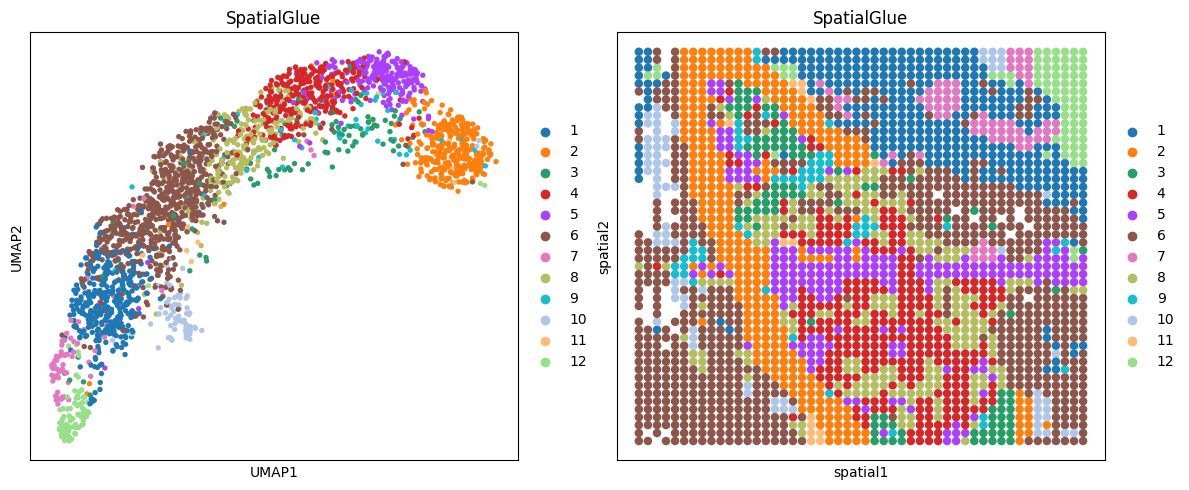

In [47]:
adata.obs['SpatialGlue'] = adata.obs['mclust_full'].astype(str)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=150, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

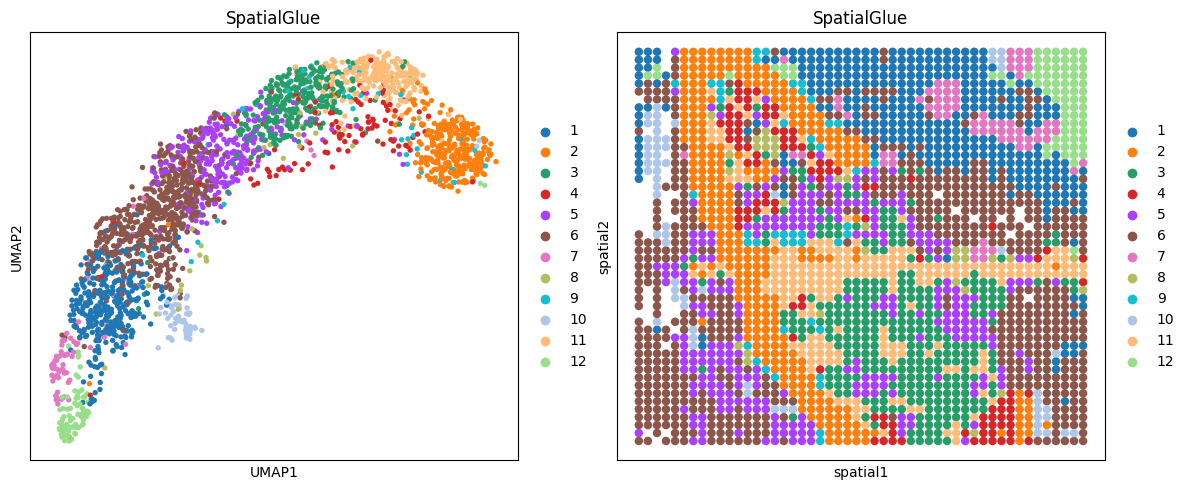

In [48]:
adata.obs['SpatialGlue'] = adata.obs['mclust_pca'].astype(str)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=150, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()